In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import mlflow
import mlflow.tensorflow
from mlflow.tracking import MlflowClient
import logging
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)

In [2]:
# Data Lake params
silver = './data/silver/stock-prices/'
gold = './data/gold/portfolio-optimization/'
silver_table = 'stock_prices.csv'
gold_table = 'portfolio_optimization.csv'

if not os.path.exists(silver):
    os.mkdir(silver)
if not os.path.exists(gold):
    os.mkdir(gold)

# Model params
ticker = ['AAPL','MSFT'] #,'AMZN','TSLA','GOOGL','GOOG','NVDA','BRK-B','META','UNH','^GSPC']
metric_to_predict = 'Adj Close'
days_to_predict = 3 # Short-term future days to predict
pred_span_days = 60 # Set the number of days used for prediction
backward_steps = 180 # Set the backward steps to go from the last observation available

# Model hyperparms
units = [32]
dropout_rate = [0.1]
learning_rate = [0.01]
epochs = [1]
batch_size = [20]

# Experiment
experiment_name = 'Stock Price Prediction'
model_name = 'spp_model'

In [3]:
# Model pipeline
def train_spp_model(ticker, model_name=model_name):
    # Function to generate the data tail to predict
    def get_data_tail(input_data, backward_steps, scaler):
        # Extract the relevant portion of the dataset for model inputs
        input_data_pred = input_data[len(input_data) - len(input_data.iloc[-backward_steps:,:]) - pred_span_days:].values

        # Reshape the model inputs to a 2D array with a single column
        input_data_pred = input_data_pred.reshape(-1, 1)

        # Apply the same scaling used for training data to the model inputs
        input_data_pred = scaler.transform(input_data_pred)

        return input_data_pred

    # Build the LSTM model
    def create_model(units, dropout_rate, learning_rate):
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, input_shape=(pred_span_days, 1)))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=int(units/2), return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=int(units/4)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model
    
    print('\n\n')
    print('********** '+ticker+' **********')
    print('\n')

    # Load the data
    input_data = pd.DataFrame(data[data['Ticker']==ticker][metric_to_predict])

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(input_data[metric_to_predict].values.reshape(-1,1))

    # Initialize empty lists for training data input and output
    x_train = []
    y_train = []

    # Iterate through the scaled data, starting from the pred_span_days index
    for x in range(pred_span_days, len(scaled_data)):
        # Append the previous 'pred_span_days' values to x_train
        x_train.append(scaled_data[x - pred_span_days:x, 0])
        # Append the current value to y_train
        y_train.append(scaled_data[x, 0])

    # Convert the x_train and y_train lists to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Extract the relevant portion of the dataset for model inputs
    input_data_pred = get_data_tail(input_data, backward_steps, scaler)

    # Initialize an empty list for test data input
    x_test = []

    # Iterate through the model inputs, starting from the pred_span_days index
    for x in range(pred_span_days, len(input_data_pred)):
        # Append the previous 'pred_span_days' values to x_test
        x_test.append(input_data_pred[x-pred_span_days:x, 0])

    # Convert the x_test list to a numpy array
    x_test = np.array(x_test)

    # Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Data to validate the predictions made
    y_test = input_data.iloc[-backward_steps:,:].values

    # Define the hyperparameters and their ranges for random search
    param_grid = {
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'batch_size': batch_size
    }

    # Define Keras Regressor
    model = KerasRegressor(build_fn=create_model, verbose=0)

    # Perform random search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=5,
        cv=3,
        random_state=42
    )
    random_search.fit(x_train, y_train)

    # Print the best hyperparameters and their corresponding score
    print('Best Parameters:', random_search.best_params_)
    print('Best Score:', random_search.best_score_)
    
    # Best model
    #best_model = random_search.best_estimator_

    # Generate price predictions using the LSTM model
    y_pred = np.reshape(random_search.predict(x_test), (-1, 1))

    # Invert the scaling applied to the predicted prices to obtain actual values
    y_pred = scaler.inverse_transform(y_pred)

    # Plot the actual and predicted prices
    plt.plot(y_test, color='black', label=f'Actual {ticker} price')
    plt.plot(y_pred, color='green', label=f'Predicted {ticker} price')
    plt.title(f'{ticker} share price')
    plt.xlabel('time')
    plt.ylabel(f'{ticker} share price')
    plt.legend()
    plt.show()

    # Calculate performance metrics
    mse = np.mean(np.power(y_test - y_pred, 2))
    rmse = np.sqrt(np.mean(np.power(y_test - y_pred, 2)))
    mae = np.mean(np.abs(y_test - y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Print errors
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Absolute Percentage Error: {mape:.4f}%')
    print('\n')
    
    # MLflow model tracking
    mlflow.set_tracking_uri('sqlite:///mlflow.db')

    mlflow_client = MlflowClient()

    # Create an MLFlow experiment, if not already exists
    experiment_details = mlflow_client.get_experiment_by_name(experiment_name)

    if experiment_details is not None:
        experiment_id = experiment_details.experiment_id
    else:
        experiment_id = mlflow.create_experiment(experiment_name)

    # Start an MLFlow experiment run
    with mlflow.start_run(experiment_id=experiment_id) as run:
        # Log parameters
        mlflow.log_params(random_search.best_params_)

        # Train the LSTM model with the best hyperparameters
        best_lstm_model = create_model(random_search.best_params_['units'], random_search.best_params_['dropout_rate'], random_search.best_params_['learning_rate'])
        best_lstm_model.fit(x_train, y_train, epochs=random_search.best_params_['epochs'], batch_size=random_search.best_params_['batch_size'], verbose=0)

        mlflow.log_metric('mse', mse)
        mlflow.log_metric('rmse', rmse)
        mlflow.log_metric('mae', mae)
        mlflow.log_metric('mape', mape)

        # Save the model
        model_name = model_name+'_'+ticker.lower()
        mlflow.tensorflow.log_model(best_lstm_model, model_name)
        
        # Register the model
        run_id = run.info.run_id
        print('Run ID: {}'.format(run_id))

        model_uri = 'runs:/{}/{}'.format(run_id, model_name)
        registered_model = mlflow.register_model(model_uri, model_name)
        print('Name: {}'.format(registered_model.name))
        print('Version: {}'.format(registered_model.version))

In [4]:
# Read data from data lake
data = pd.read_csv(silver+silver_table)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2020-05-07,75.805000,76.292503,75.492500,75.934998,74.454674,115215200,AAPL
2020-05-08,76.410004,77.587502,76.072502,77.532501,76.226830,133838400,AAPL
2020-05-11,77.025002,79.262497,76.809998,78.752502,77.426292,145946400,AAPL
2020-05-12,79.457497,79.922501,77.727501,77.852501,76.541443,162301200,AAPL
2020-05-13,78.037498,78.987503,75.802498,76.912498,75.617271,200622400,AAPL





********** AAPL **********


Best Parameters: {'units': 32, 'learning_rate': 0.01, 'epochs': 1, 'dropout_rate': 0.1, 'batch_size': 20}
Best Score: -0.014658135051528612


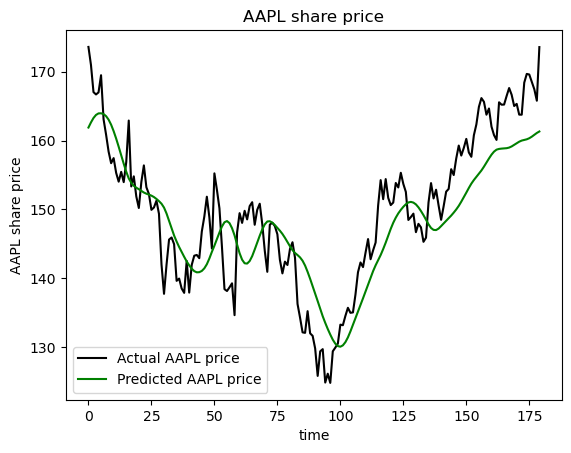

Mean Squared Error: 33.5010
Root Mean Squared Error: 5.7880
Mean Absolute Error: 4.9598
Mean Absolute Percentage Error: 3.3161%




2023/05/19 12:48:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
Registered model 'spp_model_aapl' already exists. Creating a new version of this model...
2023/05/19 12:48:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: spp_model_aapl, version 2


Run ID: ad7cde24155c41a4a28e988d86c61336
Name: spp_model_aapl
Version: 2



********** MSFT **********




Created version '2' of model 'spp_model_aapl'.


Best Parameters: {'units': 32, 'learning_rate': 0.01, 'epochs': 1, 'dropout_rate': 0.1, 'batch_size': 20}
Best Score: -0.050254995469003916


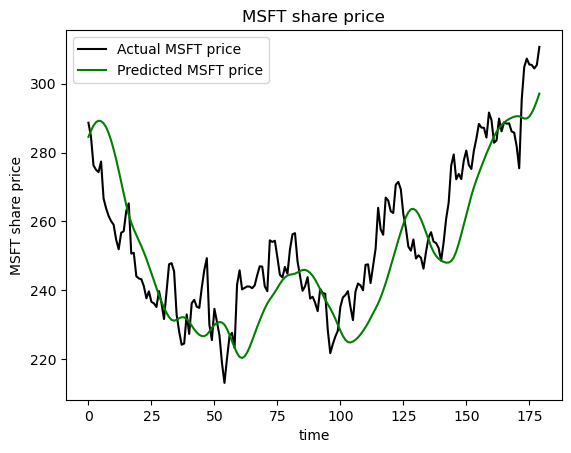

Mean Squared Error: 156.0439
Root Mean Squared Error: 12.4918
Mean Absolute Error: 10.4118
Mean Absolute Percentage Error: 4.0755%




2023/05/19 12:49:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
Successfully registered model 'spp_model_msft'.
2023/05/19 12:49:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: spp_model_msft, version 1


Run ID: 4efe1274a9714e26bf32b261279bf0b9
Name: spp_model_msft
Version: 1


Created version '1' of model 'spp_model_msft'.


In [5]:
# Model training and register
for i in ticker:
    train_spp_model(i)

In [6]:
# Model load
model_name = 'spp_model_aapl'
model_version = '1'
model_uri = 'models:/{}/{}'.format(model_name, model_version)
loaded_model = mlflow.pyfunc.load_model(model_uri)
loaded_model

2023/05/19 12:49:29 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


mlflow.pyfunc.loaded_model:
  artifact_path: spp_model_aapl
  flavor: mlflow.tensorflow
  run_id: a5bd0ff96da74d49a08fae642c35626c